## Dependencies

In [79]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt

## Reading in parameters and topology data

In [80]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

    #Volume-head relationship:
def InputHead(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column], inputdata[head_column]))
    return data_volhead
headvol_Ormset=InputHead('data/Ormset_Data.xlsx')

def InputHead2(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head2')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column].dropna(), inputdata[head_column].dropna()))
    return data_volhead
headvol_Buaset=InputHead2('data/Ormset_Data.xlsx')

    #Flow-head relationship:
def InputFlow(data_file): 
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_headflow'] = inputdata[['Moh','m3/s']].dropna()
    return data_flowhead
headflow=InputFlow('data/Ormset_Data.xlsx')

display(topology)
display(headvol_Ormset)
display(headflow)

def interpolate_head(volume, head_dict):
    volumes = list(head_dict.keys())
    heads = list(head_dict.values())
    return np.interp(volume, volumes, heads)

test=interpolate_head(45, headvol_Ormset)
print(test)


{'ormset': Ormsetfoss  Pmin  Pmax  Vmax  Vmin  Vstart  Qmin  Qmax  Pump_min  Pump_max  \
 Hydro1       0.0  43.0  45.0   0.0    45.0   0.0  12.0       0.0       0.0   
 Hydro2       0.0  30.0  20.0   0.0    20.0   0.0  12.0       0.0       1.6   
 
 Ormsetfoss    Q    LRL    HRL  RL_start  Spill_min  Spill_max  
 Hydro1      4.0  375.0  389.0     389.0        0.0       12.0  
 Hydro2      2.0  326.0  331.5     331.5        0.0       12.0  }

{0.0: 375.0,
 2.08333: 375.99242,
 4.16667: 376.83333,
 6.25: 377.63462,
 8.33333: 378.40476,
 10.41667: 379.09314,
 12.5: 379.70588,
 14.58333: 380.30093,
 16.66667: 380.87963,
 18.75: 381.45833,
 20.83333: 382.03509,
 22.91667: 382.58333,
 25.0: 383.13158,
 27.08333: 383.67982,
 29.16667: 384.22807,
 31.25: 384.77632,
 33.33333: 385.32456,
 35.41667: 385.85417,
 37.5: 386.35714,
 39.58333: 386.85317,
 41.66667: 387.33333,
 43.75: 387.79348,
 45.83333: 388.24638,
 47.91667: 388.65278,
 50.0: 389.0}

{'ormset_headflow':      Moh  m3/s
 0  388.0   0.0
 1  388.2   4.9
 2  388.5  20.4
 3  389.0  68.4}

388.0652204347847


In [108]:
start = '2018-01-01 00:00:00'
end = '2019-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

    #Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.03)

hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour

## Functions


In [105]:


# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}, 
             'states': {100: 1, 75: 0.75, 50: 0.5, 25: 0.25, 0:0 }}




# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j, s):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j, s): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j, s):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j, s ):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j, s):
    return model.v0[i]

def head_bounds(model,i,j, s):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j, s):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow

def inflow1_scenario(model, i, j, s):
    if i=='Hydro1':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 0.5)[j]
    elif i == 'Hydro2':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 0.5)[j]


# Constraints
def load_rule(model, j, s):
    return model.p['Hydro1',j, s] + model.p['Hydro2',j, s] + model.m['Buy',j, s] == model.L[j] - (model.r[j, s])

def power_rule(model,i, j, s):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j, s] == model.p[i, j, s]#MW

def vol_rule(model, i, s):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods), s ] >= model.v0[i] - tolerance



# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])


#def v_init_rule(model, i, v):
   #return model.v_init[i,v]==model.v0[i]*v/100


    
def volume_change_rule(model, i, j, s):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j , s] == (model.v_init1) - (model.q[i, j, s] *fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j, s] == (model.v_init2) - (model.q[i, j, s] *fm3)  -(model.s[i,j,s]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j , s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i =='Hydro2':
            return model.v[i, j, s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) -(model.s[i,j,s]*fm3)   
        
        
    
         
    
def OBJ_one_stage(model):
    return sum(model.probs[s] * (model.Ri*model.r[j, s] + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios ) + model.alpha


def OBJ_last_stage(model):
    return sum(model.probs[s] * (model.Ri*model.r[j, s] + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios )




## Solve one stage setup


In [106]:
def solve_last_stage(constants, topology, stage, states):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
    
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_last_stage, sense=pyo.minimize)
    
        
    return model
    


def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True) 
            
    return results, model

def displayresults(model):
    return print(model.dual.display())




In [109]:
stages=reversed(range(1, 52 + 1, 1))
scenarios= ['High', 'Avg', 'Low']
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

expected={}
end_volume={}
alpha_test={}
Dual_values1={}
Dual_values2={}
for state in state_combinations: 
        m=solve_last_stage(constants, topology, 52, state)
        solve(m)
        expected[52,state]=m.obj()/len(m.scenarios)
        alpha_test[52, state]= m.obj()/len(m.scenarios)
        Dual_values1[52, state]= (m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'High'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Avg'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Low'])))/len(m.scenarios)
        Dual_values2[52, state]= (m.dual.get((m.volume_change_cons['Hydro2', max(m.periods), 'High'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Avg'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Low'])))/len(m.scenarios)
        





Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3549 rows, 8619 columns and 10635 nonzeros
Model fingerprint: 0x09175e2d
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  Objective range  [1e+01, 2e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [3e-02, 9e+01]
Presolve removed 2560 rows and 5670 columns
Presolve time: 0.01s
Presolved: 989 rows, 2949 columns, 3932 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2379694e+04   2.258873e+01   0.000000e+00      0s
    1410    2.5622417e+05   0.000000e+00   0.000000e+00      0s

Solved in 1410 iterations and 0.03 seconds (0.02 work units)
Optimal objective  2.562241657e+05
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64

In [95]:
print(expected)
print(end_volume)
print(Dual_values1)
print(Dual_values2)


{(52, (0, 0)): 297178.91123228456, (52, (0, 4)): 241103.09103064938, (52, (0, 8)): 219697.38333380435, (52, (0, 12)): 219697.38333380435, (52, (0, 16)): 219697.38333380435, (52, (0, 20)): 219697.38333380435, (52, (9, 0)): 266874.09646344796, (52, (9, 4)): 210798.27626181257, (52, (9, 8)): 189392.56856496775, (52, (9, 12)): 189392.56856496775, (52, (9, 16)): 189392.56856496775, (52, (9, 20)): 189392.56856496775, (52, (18, 0)): 266874.09646344796, (52, (18, 4)): 210798.27626181257, (52, (18, 8)): 189392.56856496775, (52, (18, 12)): 189392.56856496775, (52, (18, 16)): 189392.56856496775, (52, (18, 20)): 189392.56856496775, (52, (27, 0)): 266874.09646344796, (52, (27, 4)): 210798.27626181257, (52, (27, 8)): 189392.56856496775, (52, (27, 12)): 189392.56856496775, (52, (27, 16)): 189392.56856496775, (52, (27, 20)): 189392.56856496775, (52, (36, 0)): 266874.09646344796, (52, (36, 4)): 210798.27626181257, (52, (36, 8)): 189392.56856496775, (52, (36, 12)): 189392.56856496775, (52, (36, 16)): 18

In [102]:
def solve_one_stage(constants, topology, stage, states, alpha_values, dual_res1, dual_res2):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
    
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    
    #Creating future cost variable
    model.alpha=pyo.Var()
 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    model.alpha_cons=pyo.ConstraintList()
    
    phi_values = []
    lambda1_values = []
    lambda2_values =[]
    state_volumes=[]
    # Calculate b values
    for key in alpha_values:
        if key[0]==stage+1:
            state_volumes.append(key[1])
            phi_values.append(alpha_values[key])
            lambda1_values.append(dual_res1[key])
            lambda2_values.append(dual_res2[key])
        else:
            pass
    
    # Calculate x values
    for i in range(len(state_volumes)):
        model.alpha_cons.add(model.alpha >= phi_values[i] - lambda1_values[i]*(sum(model.v['Hydro1', max(model.periods), s] for s in model.scenarios)/len(model.scenarios)  - (state_volumes[i][0])) - lambda2_values[i]*(sum(model.v['Hydro2', max(model.periods), s] for s in model.scenarios)/len(model.scenarios)  - (state_volumes[i][1]))) 
            
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_one_stage, sense=pyo.minimize)
    
        
    return model
    

In [110]:
stages=reversed(range(50, 51 + 1, 1))
scenarios= ['High', 'Avg', 'Low']
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]


for stage in stages:
    for state in state_combinations:
        m2=solve_one_stage(constants, topology, stage, state, expected, Dual_values1, Dual_values2)
        solve(m2)
        expected[stage, state]=(m2.obj())/len(m2.scenarios)
        alpha_test[stage, state]=(m2.alpha.value)
        end_volume[stage, state] = (m2.v['Hydro1', max(m2.periods), 'Avg'].value + m2.v['Hydro2', max(m2.periods), 'Avg'].value)
        Dual_values1[stage, state] = (m2.dual.get((m2.volume_change_cons['Hydro1', max(m2.periods), 'High'])) + m2.dual.get((m2.volume_change_cons['Hydro1', max(m2.periods), 'Avg'])) + m2.dual.get((m2.volume_change_cons['Hydro1', max(m2.periods), 'Low'])))/len(m2.scenarios)
        Dual_values2[stage, state] = (m2.dual.get((m2.volume_change_cons['Hydro2', max(m2.periods), 'High'])) + m2.dual.get((m2.volume_change_cons['Hydro2', max(m2.periods), 'Avg'])) + m2.dual.get((m2.volume_change_cons['Hydro2', max(m2.periods), 'Low'])))/len(m2.scenarios)
        

print(expected)
print(alpha_test)
print(end_volume)

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3585 rows, 8620 columns and 10737 nonzeros
Model fingerprint: 0x4e092421
Coefficient statistics:
  Matrix range     [4e-03, 3e+03]
  Objective range  [1e+00, 3e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [5e-03, 9e+04]
Presolve removed 2667 rows and 5872 columns
Presolve time: 0.01s
Presolved: 918 rows, 2748 columns, 3660 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1623846e+05   2.977090e+01   0.000000e+00      0s
    1593    4.6544834e+05   0.000000e+00   0.000000e+00      0s

Solved in 1593 iterations and 0.03 seconds (0.02 work units)
Optimal objective  4.654483389e+05
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (36, 2) and arg 1 with shape (36,).

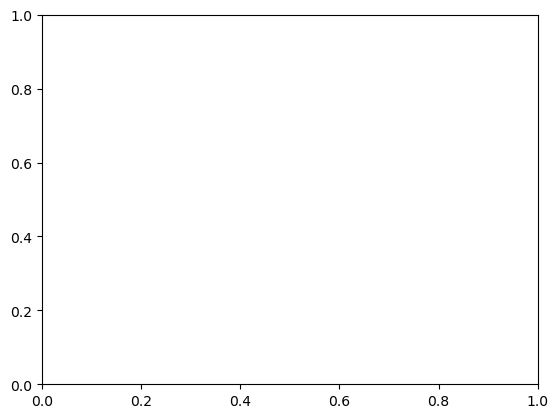

In [ ]:
states = []
values_exp = []
values_alpha=[]
values_end_vol=[]

unique_states = set()
for (stage, state), value in expected.items():
    if state not in unique_states:
        states.append(state)
        values_exp.append(value)
        unique_states.add(state)
        
        
plt.bar(states, values_exp)

# Customize the plot
plt.xlabel('State')
plt.ylabel('Value expected cost')
plt.title('Values by State')
plt.grid(True)

# Show the plot
plt.show()

unique_states = set()
for (stage, state), value in expected.items():
    if state not in unique_states:
        states.append(state)
        values_alpha.append(value)
        unique_states.add(state)

plt.bar(states, values_alpha)

# Customize the plot
plt.xlabel('State')
plt.ylabel('Value alpha')
plt.title('Values by State')
plt.grid(True)

# Show the plot
plt.show()
    

unique_states = set()
for (stage, state), value in expected.items():
    if state not in unique_states:
        states.append(state)
        values_end_vol.append(value)
        unique_states.add(state)




plt.bar(states, values_end_vol)

# Customize the plot
plt.xlabel('State')
plt.ylabel('Value end volume')
plt.title('Values by State')
plt.grid(True)

# Show the plot
plt.show()